# Exploratory data analysis of the data from patient 12

---

In this notebook we will analyze PBMC data set from patient 12 obtained from blood samples taken at 3 different time points before, during and after the proton therapy treatment. The treatment takes approximately 6 weeks with multiple sessions.

The patient is 53 year old female that has Neuroblastoma. At each time point 10ml blood were taken and the PBMCs were purifried, stained with DAPI, CD8 and CD4 and imaged with 16bit at a resolution of 0.09 micron in x-y direction, respectively 0.5 micron in z-direction. Each FoV is of the size of (1024x1024x40) pixels.

The data will be compared with a control data set of PBMCs purified from blood of 10 healthy volunteers of varying sex and age (24-60). In this analyses we will mainly focus on the assessment of the relative abundance of the different cell types during the treatment progression. In addition we aim to evaluate the descriptive power of the extracted morphological and chromatin organizational features for identifying the cell type.

---

## 0. Environmental setup

In [1]:
import random
import numpy as np
import pandas as pd
import sys
import os

from statannot import add_stat_annotation

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

sys.path.append("../../../../../")
from src.utils.notebooks.eda import *

seed = 1234
random.seed(seed)
np.random.seed(seed)

%reload_ext nb_black

<IPython.core.display.Javascript object>

## 1. Read in data

Next, we read in the data sets that describe the PBMC population of the healthy controls as well as of patient 11 at the different time points over the course of the treatment.

In [2]:
hv_basedir = "../../../../../data/pbmc_hv/marker/"
hv_subdirs = [f.path for f in os.scandir(hv_basedir) if f.is_dir()]
hv_datas = []
for hv_subdir in hv_subdirs:
    sample = os.path.split(hv_subdir)[1].split("_")[0].lower()
    data = read_in_data(
        feature_file_path=hv_subdir
        + "/preprocessed/full_pipeline/nuclear_features.csv",
        qc_file_path=hv_subdir
        + "/preprocessed/full_pipeline/segmentation/qc_results.csv",
        sample=sample,
    )
    hv_labels = pd.read_csv(
        hv_subdir + "/preprocessed/full_pipeline/marker_labels/marker_labels.csv",
        index_col=0,
    )
    data = data.merge(hv_labels, left_index=True, right_index=True)
    hv_datas.append(data)
hv_data = hv_datas[0].copy()
for i in range(1, len(hv_datas)):
    hv_data = hv_data.append(hv_datas[i])
hv_data["condition"] = "ctrl"

<IPython.core.display.Javascript object>

In [3]:
p12_1_basedir = "../../../../../data/pbmc_pt/marker/timepoint_1/P12_1_PBMCs_Dapi_CD8_CD4_20_08_21_2X_16bit"
p12_1_data = read_in_data(
    feature_file_path=p12_1_basedir
    + "/preprocessed/full_pipeline/nuclear_features.csv",
    qc_file_path=p12_1_basedir
    + "/preprocessed/full_pipeline/segmentation/qc_results.csv",
    sample="p12_1",
)

p12_1_labels = pd.read_csv(
    p12_1_basedir + "/preprocessed/full_pipeline/marker_labels/marker_labels.csv",
    index_col=0,
)
p12_1_data = p12_1_data.merge(p12_1_labels, left_index=True, right_index=True)
p12_1_data["condition"] = "tp1"

<IPython.core.display.Javascript object>

In [4]:
p12_2_basedir = "../../../../../data/pbmc_pt/marker/timepoint_2/P12_2_PBMCs_Dapi_CD8_CD4_16_09_21_2X_16bit"
p12_2_data = read_in_data(
    feature_file_path=p12_2_basedir
    + "/preprocessed/full_pipeline/nuclear_features.csv",
    qc_file_path=p12_2_basedir
    + "/preprocessed/full_pipeline/segmentation/qc_results.csv",
    sample="p12_2",
)

p12_2_labels = pd.read_csv(
    p12_2_basedir + "/preprocessed/full_pipeline/marker_labels/marker_labels.csv",
    index_col=0,
)
p12_2_data = p12_2_data.merge(p12_2_labels, left_index=True, right_index=True)
p12_2_data["condition"] = "tp2"

<IPython.core.display.Javascript object>

In [5]:
p12_3_basedir = "../../../../../data/pbmc_pt/marker/timepoint_3/P12_3_PBMCs_Dapi_CD8_CD4_12_10_21_2X_16bit"
p12_3_data = read_in_data(
    feature_file_path=p12_3_basedir
    + "/preprocessed/full_pipeline/nuclear_features.csv",
    qc_file_path=p12_3_basedir
    + "/preprocessed/full_pipeline/segmentation/qc_results.csv",
    sample="p12_3",
)

p12_3_labels = pd.read_csv(
    p12_3_basedir + "/preprocessed/full_pipeline/marker_labels/marker_labels.csv",
    index_col=0,
)
p12_3_data = p12_3_data.merge(p12_3_labels, left_index=True, right_index=True)
p12_3_data["condition"] = "tp3"

<IPython.core.display.Javascript object>

We will randomly subsample the data from each condition to the same sample size that is the minimum number of samples in any of the conditions.

In [6]:
np.random.seed(seed)
n_control_samples = np.min(
    [len(hv_data), len(p12_1_data), len(p12_2_data), len(p12_3_data)]
)
data = (
    hv_data.iloc[np.random.choice(len(hv_data), size=n_control_samples, replace=False)]
    .append(
        p12_1_data.iloc[
            np.random.choice(len(p12_1_data), size=n_control_samples, replace=False)
        ]
    )
    .append(
        p12_2_data.iloc[
            np.random.choice(len(p12_2_data), size=n_control_samples, replace=False)
        ]
    )
    .append(
        p12_3_data.iloc[
            np.random.choice(len(p12_3_data), size=n_control_samples, replace=False)
        ]
    )
)
data.describe()

,label,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,...,max_cd4_3d_int,mean_cd4_3d_int,std_cd4_3d_int,q25_cd4_3d_int,q75_cd4_3d_int,median_cd4_3d_int,kurtosis_cd4_3d_int,skewness_cd4_3d_int,cd8,cd4
count,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,...,1620.000000,1620.000000,1620.000000,1620.0,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000
mean,6.388272,61.383951,79.876543,0.776503,24.168966,41.021559,33.876589,33.585527,24.237430,30.670390,...,27425.318519,1353.142669,1947.408815,0.0,153.241049,593.783025,196.037196,8.827475,0.131481,0.249383
std,3.997898,5.912539,9.547169,0.095225,5.057812,5.436715,2.611410,2.539790,5.112474,2.704509,...,18939.844998,2427.665593,2733.982699,0.0,241.287865,1384.680803,417.489950,4.599081,0.338031,0.432789
min,1.000000,34.000000,53.000000,0.353846,0.172809,27.483711,20.325957,20.041127,0.172809,15.451336,...,5550.000000,102.773199,270.349408,0.0,26.000000,0.000000,15.427308,3.427292,0.000000,0.000000
25%,3.000000,57.000000,73.000000,0.725206,21.908844,37.014431,32.021571,31.751334,21.911538,29.056443,...,12463.750000,269.562055,671.417878,0.0,69.000000,25.000000,61.633554,6.360123,0.000000,0.000000
50%,6.000000,61.000000,78.000000,0.789474,25.079624,39.911332,33.679170,33.333477,25.106147,30.669968,...,19953.500000,361.573602,820.697869,0.0,83.000000,45.000000,109.001203,8.200496,0.000000,0.000000
75%,9.000000,65.000000,85.000000,0.848837,27.591446,43.885072,35.680818,35.338913,27.662191,32.381297,...,37539.750000,912.723587,1621.770696,0.0,107.000000,145.500000,164.211668,9.742175,0.000000,0.000000
max,20.000000,78.000000,130.000000,0.959459,33.390398,71.776505,42.499319,40.741605,38.012784,37.995263,...,65535.000000,13052.474585,14933.530972,0.0,3380.250000,7149.500000,7247.594928,63.694892,1.000000,1.000000


<IPython.core.display.Javascript object>

In [7]:
data["cd8_cd4"] = np.repeat("cd8+", len(data))
data.loc[(data["cd8"] == 0) & (data["cd4"] == 1), "cd8_cd4"] = "cd4+"
data.loc[(data["cd8"] == 1) & (data["cd4"] == 1), "cd8_cd4"] = "++"
data.loc[(data["cd8"] == 0) & (data["cd4"] == 0), "cd8_cd4"] = "--"
data.head()

,label,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,...,q75_cd4_3d_int,median_cd4_3d_int,kurtosis_cd4_3d_int,skewness_cd4_3d_int,qc_pass,sample,cd8,cd4,condition,cd8_cd4
HV3_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_15_1,2,62.0,73.0,0.849315,27.075211,36.618839,33.692788,33.083400,27.075211,31.977820,...,67.0,35.0,68.414261,6.821824,True,hv3,0,0,ctrl,--
HV1_PBMCs_Dapi_CD8_CD4_28_07_21_2X_16bit_2X_12_1,2,61.0,68.0,0.897059,28.236203,34.173887,31.999764,31.457115,28.236203,30.073174,...,185.0,2348.5,38.369247,5.428392,True,hv1,0,1,ctrl,cd4+
HV1_PBMCs_Dapi_CD8_CD4_28_07_21_2X_16bit_2X_28_7,8,70.0,79.0,0.886076,28.639635,40.517062,35.542460,35.662194,28.639635,33.790440,...,85.0,119.0,77.802380,6.634183,False,hv1,0,0,ctrl,--
HV1_PBMCs_Dapi_CD8_CD4_28_07_21_2X_16bit_2X_6_3,4,63.0,77.0,0.818182,20.921304,39.470772,33.504749,32.764202,20.921304,30.173100,...,150.0,2444.0,36.880072,5.367284,True,hv1,0,1,ctrl,cd4+
HV6_PBMCs_Dapi_CD8_CD4_10_09_21_2X_16bit_2X_36_5,6,57.0,70.0,0.814286,25.136683,35.672687,31.826283,31.086332,25.136683,28.728950,...,1075.0,4654.0,24.248269,4.442917,True,hv6,0,1,ctrl,cd4+


<IPython.core.display.Javascript object>

---

## 2. Dimensionality reduction

Next, we will clean the data and remove samples with missing values, constant features as well as those samples that were flagged for not passing our quality checks.

In [8]:
data = preprocess_data(data)
sample_labels = data.loc[:, "sample"]
condition_labels = data.loc[:, "condition"]
cd8_cd4_label = data.loc[:, "cd8_cd4"]

Nuclei that did not pass the quality check: 61/1620. Remaining: 1559.
Removed 20 constant or features with missing values. Remaining: 261.
Removed additional 6 features. Remaining: 255.


<IPython.core.display.Javascript object>

In [9]:
features = data.iloc[:, :-6]
nmco_features = features.copy()
nmco_features = nmco_features.loc[:, ~nmco_features.columns.str.contains("cd8")]
nmco_features = nmco_features.loc[:, ~nmco_features.columns.str.contains("cd4")]
nmco_features.head()

,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,d75_radius,...,rdp_8,rel_dna_3d_int,min_dna_3d_int,max_dna_3d_int,mean_dna_3d_int,std_dna_3d_int,q75_dna_3d_int,median_dna_3d_int,kurtosis_dna_3d_int,skewness_dna_3d_int
HV3_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_15_1,62.0,73.0,0.849315,27.075211,36.618839,33.692788,33.083400,27.075211,31.977820,34.531775,...,0.758411,25765.219450,3797,57537,25765.219450,8860.655750,782.0,25423.5,10.065264,3.254918
HV1_PBMCs_Dapi_CD8_CD4_28_07_21_2X_16bit_2X_12_1,61.0,68.0,0.897059,28.236203,34.173887,31.999764,31.457115,28.236203,30.073174,32.719471,...,0.769312,33879.073020,6996,65535,33879.073020,10173.528298,817.0,33956.5,10.004976,3.282391
HV1_PBMCs_Dapi_CD8_CD4_28_07_21_2X_16bit_2X_6_3,63.0,77.0,0.818182,20.921304,39.470772,33.504749,32.764202,20.921304,30.173100,35.621178,...,0.781014,29283.985183,5858,65463,29283.985183,9824.615338,561.0,29176.0,13.939276,3.771617
HV6_PBMCs_Dapi_CD8_CD4_10_09_21_2X_16bit_2X_36_5,57.0,70.0,0.814286,25.136683,35.672687,31.826283,31.086332,25.136683,28.728950,33.230319,...,0.757475,24146.090390,4452,54251,24146.090390,8206.335738,843.0,23840.0,9.244677,3.139487
HV8_PBMCs_Dapi_CD8_CD4_10_09_21_2X_16bit_2X_12_2,60.0,71.0,0.845070,27.911643,35.572293,31.503652,31.601248,27.911643,30.003665,33.085560,...,0.759119,29167.517870,5037,65535,29167.517870,10282.887924,813.0,28561.0,10.985280,3.371256


<IPython.core.display.Javascript object>

Finally, we will reduce the dimensionality of the data set further by removing highly correlated features ($\rho > 0.8$).

In [10]:
nmco_features = features = remove_correlated_features(nmco_features, threshold=0.8)

Removed 160/214 features with a Pearson correlation above 0.8. Remaining: 54


<IPython.core.display.Javascript object>

There are 54 features that remain which have correlation of less than 0.8 to any other features.

---

## 3. Data visualization

Next, we will visualize the data set using TSNE. To this end, we will first z-score the data.

In [11]:
nmco_features_sc = pd.DataFrame(
    StandardScaler().fit_transform(nmco_features),
    index=nmco_features.index,
    columns=nmco_features.columns,
)
nmco_features_sc.describe()

,min_calliper,max_calliper,smallest_largest_calliper,min_radius,med_radius,area_bbarea,avg_curvature,std_curvature,npolarity_changes,max_posi_curv,...,moments_central-0-1,moments_central-1-0,moments_hu-4,moments_hu-6,equivalent_diameter.1,extent,rel_hc_volume,rdp_1,min_dna_3d_int,q75_dna_3d_int
count,1.559000e+03,1.559000e+03,1.559000e+03,1.559000e+03,1.559000e+03,1.559000e+03,1.559000e+03,1.559000e+03,1559.000000,1.559000e+03,...,1.559000e+03,1.559000e+03,1559.000000,1.559000e+03,1.559000e+03,1.559000e+03,1.559000e+03,1.559000e+03,1.559000e+03,1.559000e+03
mean,2.734610e-16,7.109985e-16,-1.002690e-16,-2.552302e-16,-1.950688e-15,-3.008071e-16,-7.292292e-17,-3.828453e-16,0.000000,-1.002690e-16,...,-7.975945e-18,-9.115365e-18,0.000000,-4.557683e-18,-5.833834e-16,-1.549612e-16,9.115365e-16,-3.646146e-17,-9.115365e-17,3.281532e-16
std,1.000321e+00,1.000321e+00,1.000321e+00,1.000321e+00,1.000321e+00,1.000321e+00,1.000321e+00,1.000321e+00,1.000321,1.000321e+00,...,1.000321e+00,1.000321e+00,1.000321,1.000321e+00,1.000321e+00,1.000321e+00,1.000321e+00,1.000321e+00,1.000321e+00,1.000321e+00
min,-4.070965e+00,-2.838867e+00,-4.490210e+00,-4.770228e+00,-5.169370e+00,-5.723377e+00,-4.270650e+00,-2.442710e+00,-2.252737,-1.524193e+00,...,-4.505703e+00,-5.482552e+00,-7.622803,-1.934370e+01,-5.287925e+00,-4.489255e+00,-5.820497e+00,-9.356360e-01,-2.126705e+00,-3.604426e+00
25%,-6.081570e-01,-7.277271e-01,-5.491192e-01,-4.544235e-01,-7.253672e-01,-5.011132e-01,-6.782070e-01,-7.914293e-01,-0.679290,-5.579017e-01,...,-5.666366e-01,-6.464471e-01,-0.032856,3.441681e-02,-6.764678e-01,-6.133229e-01,-7.057180e-01,-8.124709e-01,-7.603613e-01,-5.228987e-01
50%,8.440455e-02,-1.999421e-01,1.285930e-01,1.833868e-01,-9.145446e-02,1.453436e-01,5.028857e-02,-1.084703e-03,-0.099599,-2.573973e-01,...,-1.740077e-04,-1.068221e-02,-0.032803,3.448881e-02,-3.492719e-01,9.928090e-02,-3.510535e-02,-3.253378e-01,-5.887757e-02,-8.920223e-02
75%,6.038257e-01,5.389568e-01,7.552457e-01,6.721000e-01,6.994930e-01,6.492943e-01,6.688282e-01,6.985069e-01,0.480092,1.204328e-01,...,5.786194e-01,6.429236e-01,-0.032759,3.455410e-02,3.978702e-01,6.986604e-01,6.970776e-01,5.100273e-01,6.281680e-01,5.765598e-01
max,2.854651e+00,5.289021e+00,1.921328e+00,1.818095e+00,3.091622e+00,2.239465e+00,6.118962e+00,4.605254e+00,6.939507,9.691150e+00,...,5.385121e+00,6.209784e+00,30.951030,1.571902e+01,3.600923e+00,2.920433e+00,2.484330e+00,4.919144e+00,6.277014e+00,4.354284e+00


<IPython.core.display.Javascript object>

Next, we compute the TSNE.

In [12]:
tsne = TSNE(random_state=seed)
tsne_embs = tsne.fit_transform(nmco_features_sc)
tsne_embs = pd.DataFrame(
    tsne_embs, columns=["tsne_0", "tsne_1"], index=nmco_features_sc.index
)
tsne_embs.loc[:, "sample"] = np.array(data.loc[tsne_embs.index, "sample"])
tsne_embs.loc[:, "condition"] = np.array(data.loc[tsne_embs.index, "condition"])
tsne_embs.loc[:, "cd8_cd4"] = np.array(data.loc[tsne_embs.index, "cd8_cd4"])

<IPython.core.display.Javascript object>

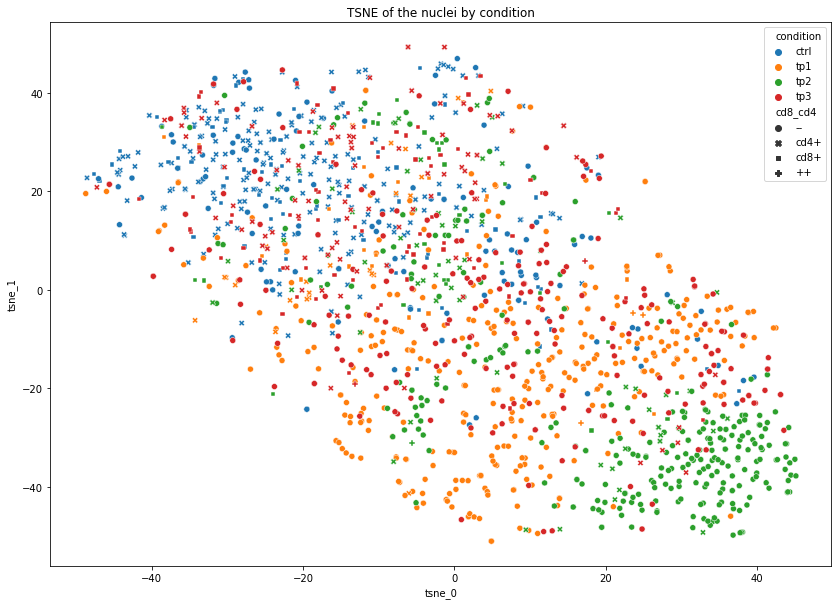

<IPython.core.display.Javascript object>

In [13]:
fig, ax = plt.subplots(figsize=[14, 10])
ax = sns.scatterplot(
    data=tsne_embs, x="tsne_0", y="tsne_1", hue="condition", style="cd8_cd4", ax=ax
)
plt.title("TSNE of the nuclei by condition")
plt.show()

---

## Cell type abundances

In [14]:
data["condition"]

HV3_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_15_1           ctrl
HV1_PBMCs_Dapi_CD8_CD4_28_07_21_2X_16bit_2X_12_1           ctrl
HV1_PBMCs_Dapi_CD8_CD4_28_07_21_2X_16bit_2X_6_3            ctrl
HV6_PBMCs_Dapi_CD8_CD4_10_09_21_2X_16bit_2X_36_5           ctrl
HV8_PBMCs_Dapi_CD8_CD4_10_09_21_2X_16bit_2X_12_2           ctrl
                                                           ... 
P12_3rd point_PBMCs_Dapi_CD8_CD4_12_10_21_2X_16bit_3_7      tp3
P12_3rd point_PBMCs_Dapi_CD8_CD4_12_10_21_2X_16bit_31_5     tp3
P12_3rd point_PBMCs_Dapi_CD8_CD4_12_10_21_2X_16bit_23_8     tp3
P12_3rd point_PBMCs_Dapi_CD8_CD4_12_10_21_2X_16bit_14_5     tp3
P12_3rd point_PBMCs_Dapi_CD8_CD4_12_10_21_2X_16bit_19_7     tp3
Name: condition, Length: 1559, dtype: object

<IPython.core.display.Javascript object>

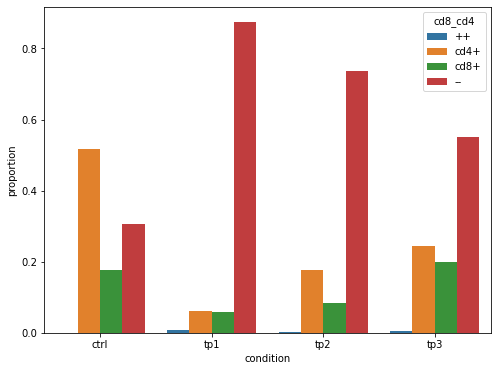

<IPython.core.display.Javascript object>

In [15]:
fig, ax = plt.subplots(figsize=[8, 6])
x, y, hue = "condition", "proportion", "cd8_cd4"
hue_order = ["++", "cd4+", "cd8+", "--"]

l = (
    data[x]
    .sort_values(ascending=True)
    .groupby(data[hue])
    .value_counts()
    .rename(y)
    .reset_index()
)
for cond in np.unique(l["condition"]):
    l.loc[l["condition"] == cond, "proportion"] /= np.sum(
        l.loc[l["condition"] == cond, "proportion"]
    )
l.pipe(
    (sns.barplot, "data"),
    x=x,
    y=y,
    hue=hue,
    order=["ctrl", "tp1", "tp2", "tp3"],
    hue_order=hue_order,
    ax=ax,
)
plt.show()

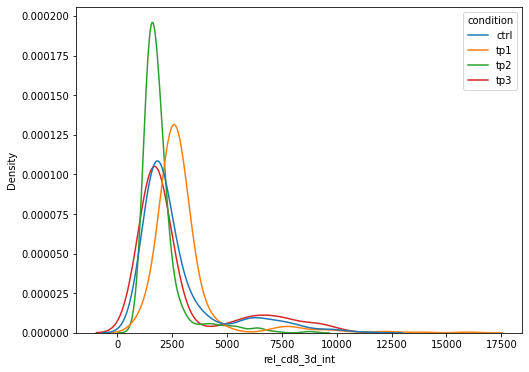

<IPython.core.display.Javascript object>

In [16]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.kdeplot(data=data, x="rel_cd8_3d_int", hue="condition", ax=ax)
plt.show()

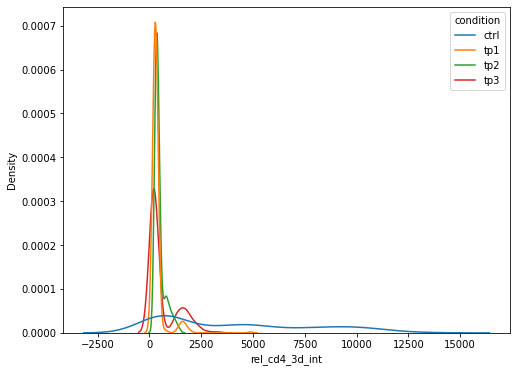

<IPython.core.display.Javascript object>

In [17]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.kdeplot(data=data, x="rel_cd4_3d_int", hue="condition", ax=ax)
plt.show()

In [18]:
np.unique(data.loc[:, "condition"])

array(['ctrl', 'tp1', 'tp2', 'tp3'], dtype=object)

<IPython.core.display.Javascript object>

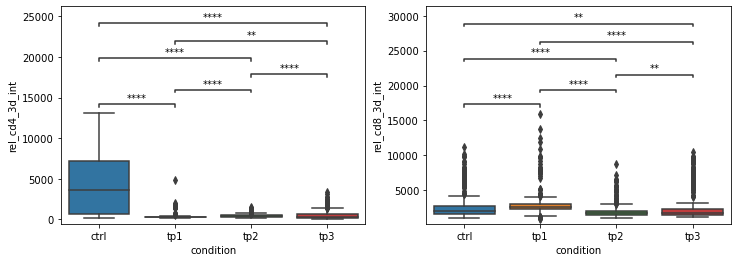

<IPython.core.display.Javascript object>

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[12, 4])
ax = ax.flatten()
ax[0] = sns.boxplot(data=data, x="condition", y="rel_cd4_3d_int", ax=ax[0])
add_stat_annotation(
    ax[0],
    data=data,
    x="condition",
    y="rel_cd4_3d_int",
    box_pairs=[
        ("ctrl", "tp1"),
        ("ctrl", "tp2"),
        ("ctrl", "tp3"),
        ("tp1", "tp2"),
        ("tp1", "tp3"),
        ("tp2", "tp3"),
    ],
    test="Mann-Whitney",
    order=["ctrl", "tp1", "tp2", "tp3"],
    loc="inside",
    verbose=0,
)
ax[1] = sns.boxplot(data=data, x="condition", y="rel_cd8_3d_int", ax=ax[1])
add_stat_annotation(
    ax[1],
    data=data,
    x="condition",
    y="rel_cd8_3d_int",
    box_pairs=[
        ("ctrl", "tp1"),
        ("ctrl", "tp2"),
        ("ctrl", "tp3"),
        ("tp1", "tp2"),
        ("tp1", "tp3"),
        ("tp2", "tp3"),
    ],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
)
plt.show()